# Augmented Embeddings Experiment

## Load images

In [485]:
import PIL
import numpy as np
import matplotlib.pyplot as plt

def load_images():
    """Load images from the folder"""
    images = []
    for i in range(4):
        img = PIL.Image.open('./data/images/' + str(i + 1) + '.png')
        img = np.array(img)
        images.append(img)
    return images

images = load_images()
TOTAL_IMAGES = len(images)

Visualise images

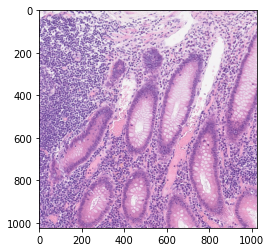

In [486]:

image = images[0]
# plt.imshow(image.rotate(0.5))
plt.imshow(image)

## Augmentation

Perform augmentations on images

In [487]:
import albumentations as A

def perform_augmentation(image, augmentation):
    """Perform given augmentation on image and crop to appropriate size for ResNet 50"""

    transform = A.Compose([
        augmentation,
        A.CenterCrop(height=224, width=224),
    ])

    transformed_image = transform(image=image)['image']
    return transformed_image

def aug_rot(image, angle):
    """Augment image with rotation (int from 0 to 360)"""

    augmentation_rotate = A.Rotate((angle, angle), always_apply=True)
    return perform_augmentation(image, augmentation_rotate)

def aug_hue(image, hue):
    """Augment image with hue (int from -100 to 100)"""

    augmentation_hue = A.HueSaturationValue(
        hue_shift_limit=(hue, hue),
        sat_shift_limit=(0, 0),
        val_shift_limit=(0, 0),
        always_apply=True
    )
    return perform_augmentation(image, augmentation_hue)


Visualise augmented images

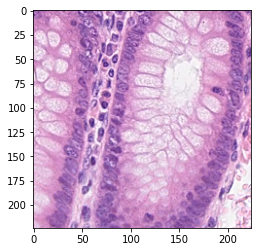

In [488]:
transformed_image = aug_rot(image=image, angle=180)
# transformed_image = aug_hue(image=image, hue=50)
plt.imshow(transformed_image)

Convert PIL images into Pytorch tensors

In [489]:
from torchvision import transforms as transform_lib

def convert_to_tensor(image):
    t = transform_lib.Compose([
        transform_lib.ToTensor(),
        transform_lib.CenterCrop(224),
        transform_lib.Normalize(
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
        )
    ])

    image_tensor =  t(image)
    return image_tensor

## Perform augmentation experiment

In [490]:
# will store everything in this dict
data = {}
for i in range(TOTAL_IMAGES):
    data[i + 1] = {}

In [491]:
def generate_aug_images(image, aug):
    aug_images = []
    for angle in range(0, 360):
        image_rot = aug(image=image, angle=angle)
        image_tensor = convert_to_tensor(image_rot)
        aug_images.append(image_tensor)
    return aug_images

In [492]:
# generate augmentations for each image
for i in range(1, TOTAL_IMAGES + 1):
    data[i]["aug_images"] = generate_aug_images(images[i - 1], aug_rot)
    print(data[i]["aug_images"][0].shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [493]:
print(len(data.keys())) # 360
print(type(data[1]["aug_images"][0])) # torch.Tensor
print(data[1]["aug_images"][0].shape) # torch.Size([3, 224, 224])

4
<class 'torch.Tensor'>
torch.Size([3, 224, 224])


## Retrieve embeddings

Modified ResNet 50 model

In [494]:
# modified from Pytorch official resnet.py
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch
from torchsummary import summary
import torch.nn.functional as F

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

class Bottleneck_Baseline(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck_Baseline, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet_Baseline(nn.Module):

    def __init__(self, block, layers):
        self.inplanes = 64
        super(ResNet_Baseline, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1) 

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        return x

def resnet50_baseline(pretrained=False):
    """Constructs a Modified ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet_Baseline(Bottleneck_Baseline, [3, 4, 6, 3])
    if pretrained:
        model = load_pretrained_weights(model, 'resnet50')
    return model

def load_pretrained_weights(model, name):
    pretrained_dict = model_zoo.load_url(model_urls[name])
    model.load_state_dict(pretrained_dict, strict=False)
    return model

Feed augmented images to ResNet 50 and save embeddings

In [495]:
model = resnet50_baseline(pretrained=True)

# only using one image for now
def get_embeddings(aug_images, batch_size=4):
    embeddings = {}
    # print(len(aug_images))
    runs = len(aug_images) // batch_size


    for i in range(runs):
        # print("Running batch {}/{}".format(i + 1, runs))
        batch = aug_images[i * batch_size : (i + 1) * batch_size]
        input = torch.stack(batch, dim=0)
        # print(input.shape)
        # input = input.cuda()

        output = model(input)
        output = output.cpu().detach().numpy()
        # print(output.shape)
        # output_list = output.tolist()
        for j in range(len(output)):
            # print(output[j].shape)
            embeddings[i * batch_size + j] = output[j]
        # print(len(embeddings[i]))
    return embeddings

In [496]:
for i in range(1, TOTAL_IMAGES + 1):
    print("Getting embeddings for image {}/{}".format(i, TOTAL_IMAGES))
    data[i]["embeddings"] = get_embeddings(data[i]["aug_images"], batch_size=4)

Getting embeddings for image 1/4
Getting embeddings for image 2/4
Getting embeddings for image 3/4
Getting embeddings for image 4/4


## Visualise results

In [497]:
import numpy as np
from sklearn.manifold import TSNE

def reduce_dims_tsne(embeddings):
    embeddings_list = np.asarray(list(embeddings.values()))
    embeddings_reduced = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(embeddings_list)
    return embeddings_reduced

In [498]:
for i in range(1, TOTAL_IMAGES + 1):
    print("Reducing embeddings for image {}/{}".format(i, TOTAL_IMAGES))
    data[i]["embeddings_reduced"] = reduce_dims_tsne(data[i]["embeddings"])

Reducing embeddings for image 1/4
Reducing embeddings for image 2/4
Reducing embeddings for image 3/4
Reducing embeddings for image 4/4


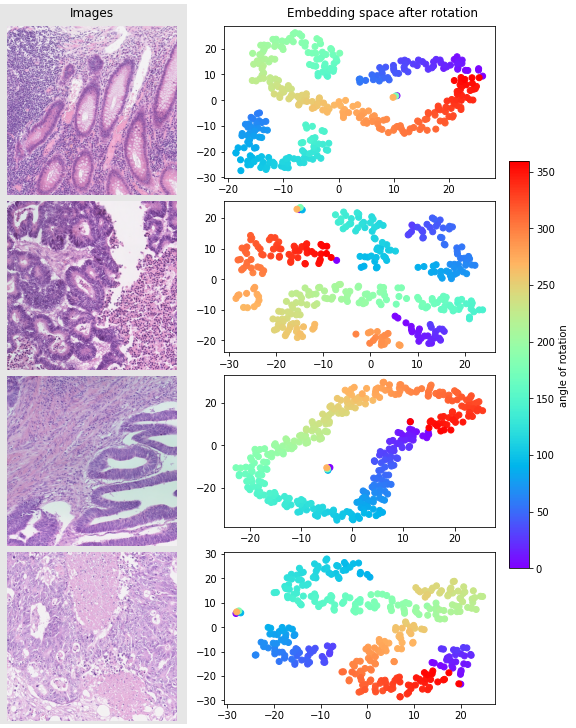

In [499]:
import matplotlib.pyplot as plt

# print(Y_embedded[:, 0].shape)
# print(Y_embedded[:, 1].shape)
# print(len(list(embeddings.keys())))

# fig, axd = plt.subplot_mosaic(
#     [['image1', 'rot1', 'hue1', 'sat1', 'val1'],
#     ['image2', 'rot2', 'hue2', 'sat2', 'val2'],
#     ['image3', 'rot3', 'hue3', 'sat3', 'val3'],
#     ['image4', 'rot4', 'hue4', 'sat4', 'val4']],
#     figsize=(5.5, 3.5), constrained_layout=True
# )

fig = plt.figure(constrained_layout=True, figsize=(8, 10))

subfigs = fig.subfigures(1, 2, width_ratios=[1, 2])

# images
axs0 = subfigs[0].subplots(4, 1)
subfigs[0].suptitle('Images')
subfigs[0].set_facecolor('0.9')
for i in range(4):
    axs0[i].imshow(images[i])
    axs0[i].axis('off')
    # axs0[i].set_title('Image {}'.format(i + 1))

axs1 = subfigs[1].subplots(4, 1)
subfigs[1].suptitle('Embedding space after rotation')

# rotation
range_rot = []
for i in range(1, TOTAL_IMAGES + 1):
    scatter = axs1[i - 1].scatter(data[i]["embeddings_reduced"][:, 0], data[i]["embeddings_reduced"][:, 1], c=list(data[i]["embeddings"].keys()), cmap='rainbow')
subfigs[1].colorbar(scatter, ax=axs1, label='angle of rotation', shrink=0.6)

# hue

# saturation

# value


plt.show()